In [2]:
from matplotlib import pyplot as plt
import numpy as np
import sklearn.model_selection as sk
from sklearn.utils import shuffle
import random
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,accuracy_score

In [3]:
# get input data from Keras datasets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
# combine x_train and x_test for later pre-processing
X = np.vstack([x_train,x_test])
y = np.append(y_train,y_test)

In [4]:
# split data by categories of 6 and 4 items
# create test2 and training dara
training_images_lab = {0:"top", 1:"trouser", 2:"pullover", 4:"coat", 5:"sandal", 9:"ankle boot"}
unseen_image_lab = {3:"dress", 7:"sneaker", 8:"bag", 6:"shirt"}
X_train = []
y_train = []
X_test = []
y_test = []
for index in range(len(y)):    
    if y[index] in training_images_lab.keys():
        X_train.append(X[index])
        y_train.append(y[index])
    else:
        X_test.append(X[index])
        y_test.append(y[index])
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test2 = np.array(X_test)
y_test2 = np.array(y_test)

In [5]:
# split training data into training and test1
X_train, X_test1, y_train, y_test1 = sk.train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# union test1 and test2
X_test3, y_test3 = np.concatenate([X_test1, X_test2]), np.concatenate([y_test1, y_test2])

In [6]:
def create_pairs(x, digit_indices):
    '''
    Positive and negative pair creation.
    x: image data
    digit_indices: location of data which arrange by categories
    '''
    pairs = []
    labels = []
    # n: minimum pairs that we can create in all category 
    n = min([len(digit_indices[d]) for d in range(len(digit_indices))]) - 1
    for d in range(len(digit_indices)):
        for i in range(n):
            # Postive Pairs
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            # Negative Pairs, randomly pick on in other category 
            inc = random.randrange(1, len(digit_indices))
            dn = (d + inc) % len(digit_indices)
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [0, 1]
    return np.array(pairs), np.array(labels)

In [7]:
# Training data - 80%
digit_indices = [np.where(y_train == i)[0] for i in list(training_images_lab.keys())]
train_x, train_y = create_pairs(X_train, digit_indices)
# Test 1 - 20% 
digit_indices = [np.where(y_test1 == i)[0] for i in list(training_images_lab.keys())]
test_x1, test_y1 = create_pairs(X_test1, digit_indices)
# Test 2 - 4 categories 
digit_indices = [np.where(y_test2 == i)[0] for i in list(unseen_image_lab.keys())]
test_x2, test_y2 = create_pairs(X_test2, digit_indices)
# Test 3 - Test1 Union Test2
all_images = list(training_images_lab.keys())+list(unseen_image_lab.keys())
digit_indices = [np.where(y_test3 == i)[0] for i in all_images]
test_x3, test_y3 = create_pairs(X_test3, digit_indices)

In [8]:
# fig, ax = plt.subplots(nrows=10, ncols=4,figsize=(40, 40))
# idx = 0
# for row in range(10):
#     idx = random.randrange(0,len(train_pairs),2)
#     ax[row,0].imshow(train_pairs[idx][0],cmap = 'gray')
#     ax[row,1].imshow(train_pairs[idx][1],cmap = 'gray')
#     idx+=1
#     ax[row,2].imshow(train_pairs[idx][0],cmap = 'gray')
#     ax[row,3].imshow(train_pairs[idx][1],cmap = 'gray')
# plt.show()

In [9]:
# add to the top of your code under import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [10]:
# Normalize train and test data
train_x = train_x.astype('float32')/255
test_x1 = test_x1.astype('float32')/255
test_x2 = test_x2.astype('float32')/255
test_x3 = test_x3.astype('float32')/255

In [11]:
# Reshape into (n, 2, 28, 28, 1)
# where n is number of examples
# img_rows and img_cols are the size of data
img_rows, img_cols = train_x.shape[2:4]
train_x = train_x.reshape(train_x.shape[0], 2 ,img_rows, img_cols, 1)
test_x1 = test_x1.reshape(test_x1.shape[0], 2, img_rows, img_cols, 1)
test_x2 = test_x2.reshape(test_x2.shape[0], 2, img_rows, img_cols, 1)
test_x3 = test_x3.reshape(test_x3.shape[0], 2, img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [12]:
# split training data into train and validation for training
train_x, val_x, train_y, val_y = sk.train_test_split(train_x, train_y, test_size=0.1, random_state=42)

In [ ]:
def eucl_dist_output_shape(shapes):
    #return the shape of embedding output
    shape1, shape2 = shapes
    return (shape1[0], 1)
def euclidean_distance(vects):
    '''
    Summary:
    compute the euclidean distance between a and b
    which a and b are ouput from two embedding layers
    the representation of embedding is highly dimensional   
    
    Variable Description:
    vects: input encoding from the last two CNN layers 
    a, b: encoding a and b, which store in vects
    sum_suqare: sum of square difference between two baseline vector (anchor) and a positive or negative vector.
    d: a vector of distance. The vector space is (n,1), which n is batch size or many examples.  
    '''
    a, b = vects
    sum_square = K.sum(K.square(a - b), axis=1, keepdims=True)
    d = K.sqrt(sum_square)
    return d
def contrastive_loss(y_true, y_pred, m = 1):
    '''
    Summary:
    This function is to compute contrastive loss
    for a postive pair, we want the embedding presentation points are in a region
    for a negative pair, we want the embedding presentation points are outside the region
    the loss function can be split into 2 part:
    Positive pair loss1: D(Pi,Pj)^2 * 0.5 , where y_true = 0
    Negative pair loss2: max(0, m - D(Pi,Pj))^2 * 0.5  , where y_true = 1    
    
    Variable Description:
    y_pred: the distance which computed by eclidean distance
    y_true: ground truth, 1: same category, 0: different category
    m: margin which used to separate positive and negative vector
    '''
    #y_ture == 0
    loss1 = tf.cast(K.equal(y_true,0),dtype = 'float32') * K.square(y_pred) * 0.5
    #y_ture == 1
    loss2 = tf.cast(K.equal(y_true,1),dtype = 'float32') * K.square(K.maximum(m - y_pred, 0)) * 0.5
    #mean of loss1 and loss2
    mean_loss = K.mean(loss1 + loss2)
    return mean_loss

In [ ]:
def accuracy(y_true, y_pred):
    '''
    Compute classification accuracy with a fixed threshold (0.5) on distance.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred > 0.5, y_true.dtype)))

In [14]:
#best model with activation function: leaky relu, dropout 20% and embedding length 64
def create_base_network(input_shape):
    '''
    input_shape: target image size
    Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation=tf.nn.leaky_relu,name='block1_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation=tf.nn.leaky_relu,name='block2_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block2_pool')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    output = Dense(64, activation=tf.nn.leaky_relu,name = 'embeding')(x)    
    
    return Model(input_tensor, output)

In [15]:
# create siamese network 
base_network = create_base_network(input_shape)
base_network.summary()
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
# because we re-use the same instance `base_network`,
# the weights of the network will be shared across the two networks
embedding_a = base_network(input_a)
embedding_b = base_network(input_b)
# compute the distance of embadding layer
distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([embedding_a, embedding_b])

model = Model([input_a, input_b], distance)
model.summary()

W1016 17:52:35.617009 26556 deprecation.py:506] From C:\Users\stu10\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 8, 8, 64)          18496     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 4, 4, 64)          0     

In [16]:
# train
epochs = 200
lr = 1e-4
adam = Adam(learning_rate=lr,decay=lr/epochs)
model.compile(loss= contrastive_loss, optimizer=adam, metrics=[accuracy])

In [17]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=1024,
          epochs=epochs,
          validation_data= ([val_x[:,0],val_x[:,1]],val_y),
          callbacks=[early_stopping_callback])

W1016 17:52:43.655410 26556 deprecation.py:323] From C:\Users\stu10\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 34s 571us/sample - loss: 0.1493 - accuracy: 0.8022 - val_loss: 0.1173 - val_accuracy: 0.8641
Epoch 2/200
60145/60145 [==============================] - 37s 614us/sample - loss: 0.1058 - accuracy: 0.8816 - val_loss: 0.0948 - val_accuracy: 0.8988
Epoch 3/200
60145/60145 [==============================] - 43s 723us/sample - loss: 0.0880 - accuracy: 0.9071 - val_loss: 0.0809 - val_accuracy: 0.9145
Epoch 4/200
60145/60145 [==============================] - 44s 736us/sample - loss: 0.0766 - accuracy: 0.9203 - val_loss: 0.0717 - val_accuracy: 0.9269
Epoch 5/200
60145/60145 [==============================] - 38s 634us/sample - loss: 0.0686 - accuracy: 0.9279 - val_loss: 0.0648 - val_accuracy: 0.9309
Epoch 6/200
60145/60145 [==============================] - 38s 633us/sample - loss: 0.0631 - accuracy: 0.9327 - val_loss: 0.0603 - val_accuracy: 0.9354
Epoch 7/200
60145/60145 [==============

KeyboardInterrupt: 

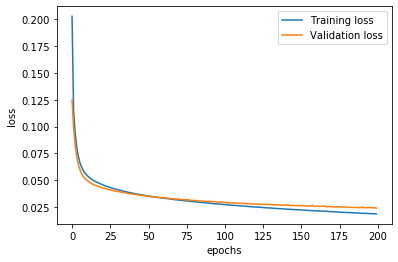

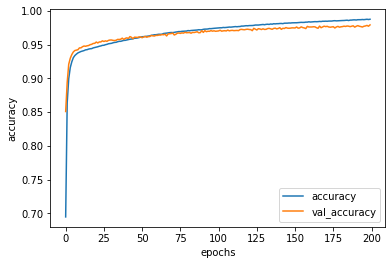

In [18]:
loss = history.history['loss'].copy()
val_loss= history.history['val_loss'].copy()
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
accuracy = history.history['accuracy'].copy()
val_accuracy = history.history['val_accuracy'].copy()
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.legend(['accuracy','val_accuracy'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [21]:
# use trained model to predict test data
# compute corresponding accuracy
pred1 = model.predict([test_x1[:,0],test_x1[:,1]])
pred2 = model.predict([test_x2[:,0],test_x2[:,1]])
pred3 = model.predict([test_x3[:,0],test_x3[:,1]])
te_acc1 = accuracy_score(test_y1, pred1>=0.5)
te_acc2 = accuracy_score(test_y2, pred2>=0.5)
te_acc3 = accuracy_score(test_y3, pred3>=0.5)
print('* Accuracy on test1 set: %0.2f%%' % (100 * te_acc1))
print('* Accuracy on test2 set: %0.2f%%' % (100 * te_acc2))
print('* Accuracy on test3 set: %0.2f%%' % (100 * te_acc3))

* Accuracy on test1 set: 96.67%
* Accuracy on test2 set: 67.76%
* Accuracy on test3 set: 82.85%


In [22]:
# analyse precision and recall
print(classification_report(test_y1,pred1>=0.5))
print(classification_report(test_y2,pred2>=0.5))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      8238
           1       0.96      0.97      0.97      8238

    accuracy                           0.97     16476
   macro avg       0.97      0.97      0.97     16476
weighted avg       0.97      0.97      0.97     16476



In [28]:
# print confusion matrix
print(confusion_matrix(test_y2,pred2>=0.5))

array([[14479, 13517],
       [ 4537, 23459]])

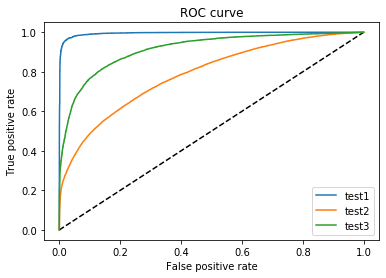

In [26]:
# plot ROC curve
fpr_rf1, tpr_rf1, _ = roc_curve(test_y1, pred1)
fpr_rf2, tpr_rf2, _ = roc_curve(test_y2, pred2)
fpr_rf3, tpr_rf3, _ = roc_curve(test_y3, pred3)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf1, tpr_rf1, label='test1')
plt.plot(fpr_rf2, tpr_rf2, label='test2')
plt.plot(fpr_rf3, tpr_rf3, label='test3')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()